# RQ4
What is the effect of increasing the number of texts retrieved and included in the prompt on the energy consumption of the entire RAG process?

# RQ5
How does energy consumption change with language model size in a RAG system?

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from results_processor import get_experiments_data, compute_total_energy_per_run, aggregate_rag_data, get_ci_deviation, compute_kruskal_wallis, compute_wilcoxon

plt.style.use("ggplot")
colors = sns.cubehelix_palette(start=2, rot=0.1, dark=0.2, light=.95, reverse=True)
color_map = sns.cubehelix_palette(start=2, rot=0.1, dark=0.2, light=.95, reverse=False, as_cmap=True)

### 1. Gemma 2 2B

In [2]:
gemma_experiments_data = get_experiments_data(
    "rq4_rq5_gemma",
    ["Total DRAM Power [W]", "IA Cores Power [W]", "GPU Rail Powers (avg) [W]"],
    ["embedding_start_time", "ask_model_end_time"],
    idle_state="Docker running",
)

gemma_runs_data = compute_total_energy_per_run(gemma_experiments_data)
gemma_retrieved_docs_variation_runs = aggregate_rag_data("rq4_rq5_gemma", gemma_runs_data)
gemma_retrieved_docs_variation_runs.insert(
    loc=3,
    column="Total Energy [J]",
    value=(
        gemma_retrieved_docs_variation_runs["CPU Cores Energy [J]"]
        + gemma_retrieved_docs_variation_runs["DRAM Energy [J]"]
        + gemma_retrieved_docs_variation_runs["GPU Energy [J]"]
    ),
)
gemma_retrieved_docs_variation_runs

,CPU Cores Energy [J],DRAM Energy [J],GPU Energy [J],Total Energy [J],duration [s],number retrieved docs,prompts_tokens_no,answers_tokens_no
run_index,,,,,,,,
0,34.696014,1.710767,40.579558,76.986339,2.400032,1,346,25
1,241.180994,13.788391,188.640301,443.609686,13.422673,1,453,207
2,119.480879,6.410297,87.354558,213.245734,6.946329,1,241,102
3,205.765972,10.739620,177.301371,393.806963,12.084191,1,390,200
4,90.287463,4.527848,93.971855,188.787167,5.509120,1,510,67
...,...,...,...,...,...,...,...,...
95,144.988798,16.373458,287.006712,448.368968,21.566297,5,1660,284
96,122.811032,13.923018,302.264664,438.998714,19.446069,5,1868,245
97,220.038704,24.772394,416.198258,661.009355,31.928821,5,1525,434


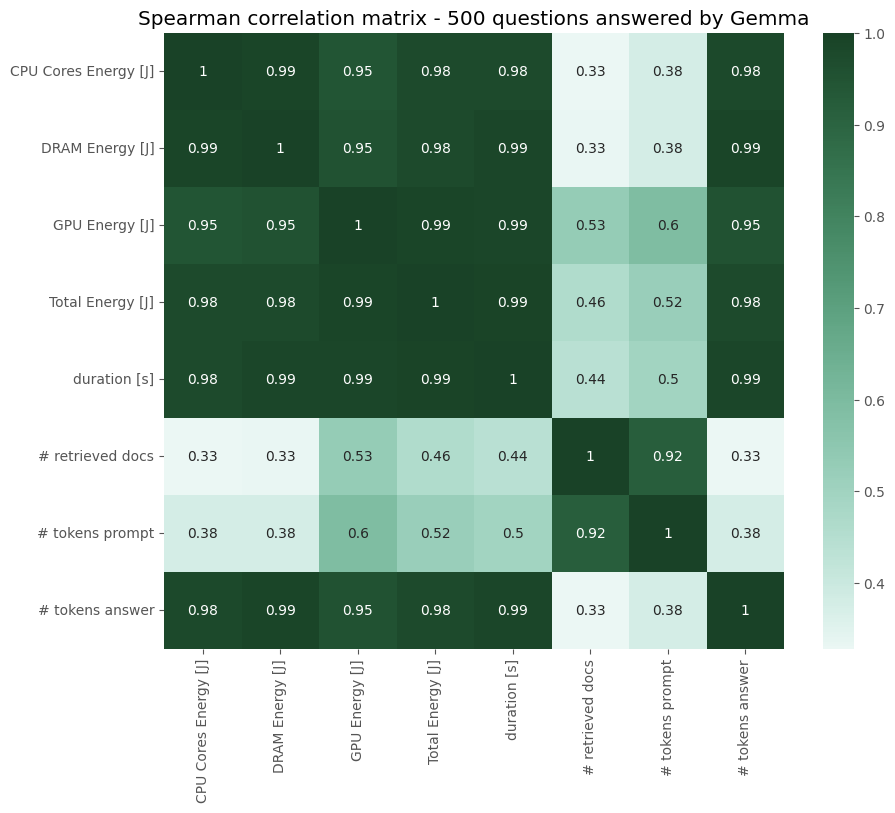

In [3]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 8)
gemma_correlations = (
    gemma_retrieved_docs_variation_runs.rename(
        {
            "number retrieved docs": "# retrieved docs",
            "prompts_tokens_no": "# tokens prompt",
            "answers_tokens_no": "# tokens answer",
        },
        axis=1,
    )
    .corr(method="spearman")
)

sns.heatmap(gemma_correlations, annot=True, cmap=color_map)
plt.title("Spearman correlation matrix - 500 questions answered by Gemma")
fig.savefig("./figures/correlations_rag_gemma.png", dpi=500, bbox_inches="tight")

In [4]:
gemma_retrieved_docs_variation_runs.groupby(
    ["number retrieved docs"]
).aggregate(lambda x: str(round(x.mean(), 2)) + " ± " + str(get_ci_deviation(x))).drop(
    ["Total Energy [J]", "answers_tokens_no"], axis=1
).reset_index().rename(
    {"number retrieved docs": "# retrieved docs", "prompts_tokens_no": "# tokens prompt"}, axis=1
).set_index(
    "# retrieved docs"
)

,CPU Cores Energy [J],DRAM Energy [J],GPU Energy [J],duration [s],# tokens prompt
# retrieved docs,,,,,
1,82.7 ± 10.55,9.03 ± 1.13,140.04 ± 16.39,10.32 ± 1.25,362.94 ± 21.99
2,83.37 ± 9.01,9.65 ± 1.05,163.44 ± 16.24,11.75 ± 1.2,681.55 ± 32.49
3,97.3 ± 10.42,11.22 ± 1.21,211.69 ± 19.6,14.38 ± 1.45,1018.26 ± 42.67
4,117.87 ± 11.65,13.41 ± 1.34,270.3 ± 21.69,17.89 ± 1.62,1353.32 ± 49.68
5,134.94 ± 12.54,15.21 ± 1.43,307.32 ± 23.05,20.35 ± 1.73,1690.76 ± 56.45


In [5]:
compute_kruskal_wallis(
    gemma_retrieved_docs_variation_runs, "number retrieved docs", [1, 2, 3, 4, 5], "duration [s]"
)

KruskalResult(statistic=np.float64(97.78524838323347), pvalue=np.float64(2.912322428579741e-20))

In [6]:
compute_kruskal_wallis(
    gemma_retrieved_docs_variation_runs,
    "number retrieved docs",
    [1, 2, 3, 4, 5],
    "Total Energy [J]",
)

KruskalResult(statistic=np.float64(108.3054083832335), pvalue=np.float64(1.672423265992359e-22))

In [7]:
for i in range(4):
    print(
        i + 1,
        compute_wilcoxon(
            gemma_retrieved_docs_variation_runs,
            i + 1,
            i + 2,
            "duration [s]",
            "number retrieved docs",
        ),
    )

1 WilcoxonResult(statistic=np.float64(1787.0), pvalue=np.float64(0.0055826278200956985))
2 WilcoxonResult(statistic=np.float64(1341.0), pvalue=np.float64(2.3408224806189123e-05))
3 WilcoxonResult(statistic=np.float64(1171.0), pvalue=np.float64(1.6160410549258872e-06))
4 WilcoxonResult(statistic=np.float64(1652.0), pvalue=np.float64(0.0013425700893382885))


In [8]:
for i in range(4):
    print(
        i + 1,
        compute_wilcoxon(
            gemma_retrieved_docs_variation_runs,
            i + 1,
            i + 2,
            "Total Energy [J]",
            "number retrieved docs",
        ),
    )

1 WilcoxonResult(statistic=np.float64(1924.0), pvalue=np.float64(0.019393795433784288))
2 WilcoxonResult(statistic=np.float64(1222.0), pvalue=np.float64(3.7297524423760245e-06))
3 WilcoxonResult(statistic=np.float64(1080.0), pvalue=np.float64(3.3757384536170837e-07))
4 WilcoxonResult(statistic=np.float64(1587.0), pvalue=np.float64(0.0006295362598298078))


### 2. Llama 3.2 1B

In [9]:
llama_experiments_data = get_experiments_data(
    "rq4_rq5_llama",
    ["Total DRAM Power [W]", "IA Cores Power [W]", "GPU Rail Powers (avg) [W]"],
    ["embedding_start_time", "ask_model_end_time"],
)

llama_runs_data = compute_total_energy_per_run(llama_experiments_data)
llama_retrieved_docs_variation_runs = aggregate_rag_data("rq4_rq5_llama", llama_runs_data)
llama_retrieved_docs_variation_runs.insert(
    loc=3,
    column="Total Energy [J]",
    value=(
        llama_retrieved_docs_variation_runs["CPU Cores Energy [J]"]
        + llama_retrieved_docs_variation_runs["DRAM Energy [J]"]
        + llama_retrieved_docs_variation_runs["GPU Energy [J]"]
    ),
)
llama_retrieved_docs_variation_runs

,CPU Cores Energy [J],DRAM Energy [J],GPU Energy [J],Total Energy [J],duration [s],number retrieved docs,prompts_tokens_no,answers_tokens_no
run_index,,,,,,,,
0,42.634188,0.709738,149.768554,193.112480,5.257575,1,346,302
1,72.596294,1.806481,214.952166,289.354941,7.489050,1,453,443
2,92.873469,3.835142,227.422397,324.131008,8.162148,1,241,480
3,51.682786,1.139934,149.517573,202.340293,5.356512,1,390,320
4,48.068511,0.740236,160.986584,209.795330,5.986468,1,510,318
...,...,...,...,...,...,...,...,...
95,31.752931,2.012321,319.246182,353.011433,10.967489,5,1660,454
96,13.165170,0.770459,196.419725,210.355354,7.174188,5,1868,259
97,16.259014,0.957708,245.781110,262.997832,8.784207,5,1525,361


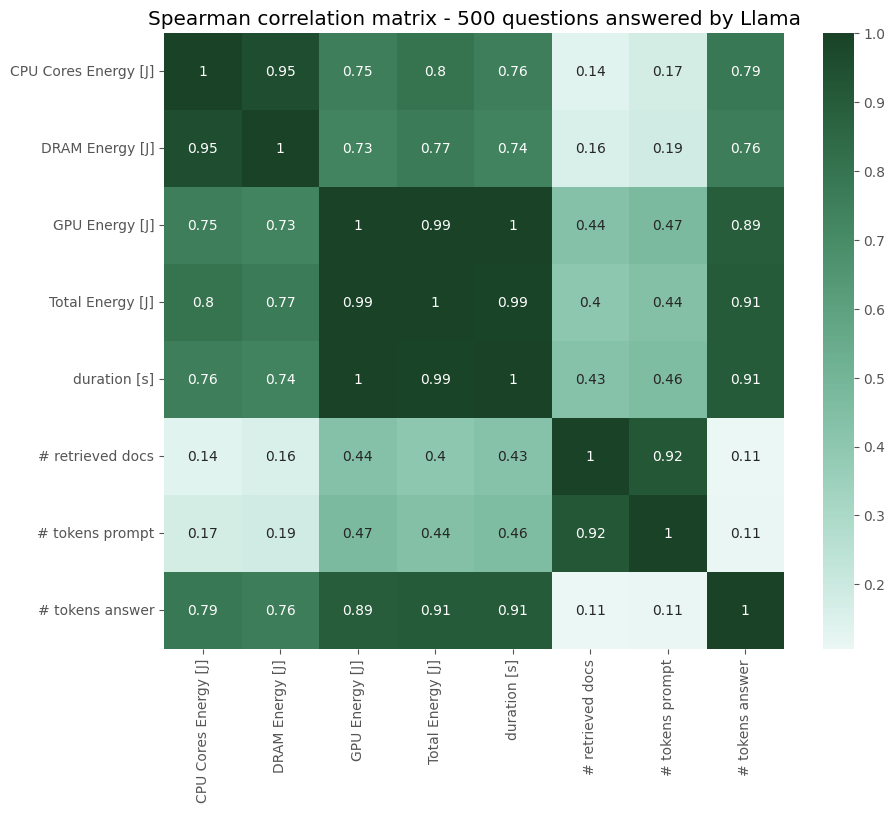

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 8)
llama_correlations = (
    llama_retrieved_docs_variation_runs.rename(
        {
            "number retrieved docs": "# retrieved docs",
            "prompts_tokens_no": "# tokens prompt",
            "answers_tokens_no": "# tokens answer",
        },
        axis=1,
    )
    .corr(method="spearman")
)

sns.heatmap(llama_correlations, annot=True, cmap=color_map)
plt.title("Spearman correlation matrix - 500 questions answered by Llama")
fig.savefig("./figures/correlations_rag_llama.png", dpi=500, bbox_inches="tight")

In [11]:
compute_kruskal_wallis(
    llama_retrieved_docs_variation_runs, "number retrieved docs", [1, 2, 3, 4, 5], "duration [s]"
)

KruskalResult(statistic=np.float64(96.66519473053904), pvalue=np.float64(5.041428937903588e-20))

In [12]:
compute_kruskal_wallis(
    llama_retrieved_docs_variation_runs,
    "number retrieved docs",
    [1, 2, 3, 4, 5],
    "Total Energy [J]",
)

KruskalResult(statistic=np.float64(85.15209389221559), pvalue=np.float64(1.4083337277644155e-17))

In [13]:
for i in range(4):
    print(
        i + 1,
        compute_wilcoxon(
            llama_retrieved_docs_variation_runs,
            i + 1,
            i + 2,
            "duration [s]",
            "number retrieved docs",
        ),
    )

1 WilcoxonResult(statistic=np.float64(1493.0), pvalue=np.float64(0.00019382545252393638))
2 WilcoxonResult(statistic=np.float64(1327.0), pvalue=np.float64(1.9016667139855487e-05))
3 WilcoxonResult(statistic=np.float64(1691.0), pvalue=np.float64(0.0020682327287513905))
4 WilcoxonResult(statistic=np.float64(2386.0), pvalue=np.float64(0.31635102717936164))


In [14]:
for i in range(4):
    print(
        i + 1,
        compute_wilcoxon(
            llama_retrieved_docs_variation_runs,
            i + 1,
            i + 2,
            "Total Energy [J]",
            "number retrieved docs",
        ),
    )

1 WilcoxonResult(statistic=np.float64(1749.0), pvalue=np.float64(0.0038136225349600984))
2 WilcoxonResult(statistic=np.float64(1275.0), pvalue=np.float64(8.620960373569475e-06))
3 WilcoxonResult(statistic=np.float64(1699.0), pvalue=np.float64(0.0022552784729734407))
4 WilcoxonResult(statistic=np.float64(2331.0), pvalue=np.float64(0.25237488236745254))


### 2. Gemma 2 2b and Llama 3.2 1B

In [15]:
gemma_retrieved_docs_variation_runs["model"] = "gemma"
llama_retrieved_docs_variation_runs["model"] = "llama"

retrieved_docs_variation_runs = pd.concat(
    [gemma_retrieved_docs_variation_runs, llama_retrieved_docs_variation_runs]
)
retrieved_docs_variation_runs

,CPU Cores Energy [J],DRAM Energy [J],GPU Energy [J],Total Energy [J],duration [s],number retrieved docs,prompts_tokens_no,answers_tokens_no,model
run_index,,,,,,,,,
0,34.696014,1.710767,40.579558,76.986339,2.400032,1,346,25,gemma
1,241.180994,13.788391,188.640301,443.609686,13.422673,1,453,207,gemma
2,119.480879,6.410297,87.354558,213.245734,6.946329,1,241,102,gemma
3,205.765972,10.739620,177.301371,393.806963,12.084191,1,390,200,gemma
4,90.287463,4.527848,93.971855,188.787167,5.509120,1,510,67,gemma
...,...,...,...,...,...,...,...,...,...
95,31.752931,2.012321,319.246182,353.011433,10.967489,5,1660,454,llama
96,13.165170,0.770459,196.419725,210.355354,7.174188,5,1868,259,llama
97,16.259014,0.957708,245.781110,262.997832,8.784207,5,1525,361,llama


In [16]:
retrieved_docs_variation_runs.groupby(["model", "number retrieved docs"]).aggregate(
    lambda x: str(round(x.mean(), 2)) + " ± " + str(get_ci_deviation(x))
)

CPU Cores Energy [J] DRAM Energy [J]  \
model number retrieved docs                                        
gemma 1                             82.7 ± 10.55     9.03 ± 1.13   
      2                             83.37 ± 9.01     9.65 ± 1.05   
      3                             97.3 ± 10.42    11.22 ± 1.21   
      4                           117.87 ± 11.65    13.41 ± 1.34   
      5                           134.94 ± 12.54    15.21 ± 1.43   
llama 1                             20.15 ± 3.32     1.17 ± 0.18   
      2                              17.3 ± 1.36     1.15 ± 0.09   
      3                             19.16 ± 1.29      1.25 ± 0.1   
      4                             19.77 ± 1.27      1.29 ± 0.1   
      5                             20.38 ± 1.52     1.32 ± 0.11   

                             GPU Energy [J] Total Energy [J]  duration [s]  \
model number retrieved docs                                                  
gemma 1                      140.04 ± 16.39   231.78 ± 27.49  10.32 ± 1.25   
      2                      163.44 ± 16.24   256.46 ± 26.17   11.75 ± 1.2   
      3                       211.69 ± 19.6   320.21 ± 31.08  14.38 ± 1.45   
      4                       270.3 ± 21.69   401.57 ± 34.52  17.89 ± 1.62   
      5                      307.32 ± 23.05   457.47 ± 36.75  20.35 ± 1.73   
llama 1                      154.94 ± 17.57   176.26 ± 20.07   5.51 ± 0.62   
      2                      185.43 ± 12.55    203.87 ± 13.7   6.72 ± 0.45   
      3                      224.37 ± 12.57   244.78 ± 13.71   8.04 ± 0.46   
      4                      252.86 ± 14.74   273.92 ± 15.93   9.03 ± 0.53   
      5                      259.22 ± 16.67   280.92 ± 18.06   9.23 ± 0.61   

                            prompts_tokens_no answers_tokens_no  
model number retrieved docs                                      
gemma 1                        362.94 ± 21.99    153.34 ± 20.08  
      2                        681.55 ± 32.49    166.12 ± 18.89  
      3                       1018.26 ± 42.67    194.19 ± 22.17  
      4                       1353.32 ± 49.68     235.12 ± 24.2  
      5                       1690.76 ± 56.45    262.31 ± 25.15  
llama 1                        362.94 ± 21.99    321.42 ± 37.63  
      2                        681.55 ± 32.49    356.26 ± 24.97  
      3                       1018.26 ± 42.67     384.59 ± 21.7  
      4                       1353.32 ± 49.68    395.17 ± 25.11  
      5                       1690.76 ± 56.45    377.31 ± 28.04

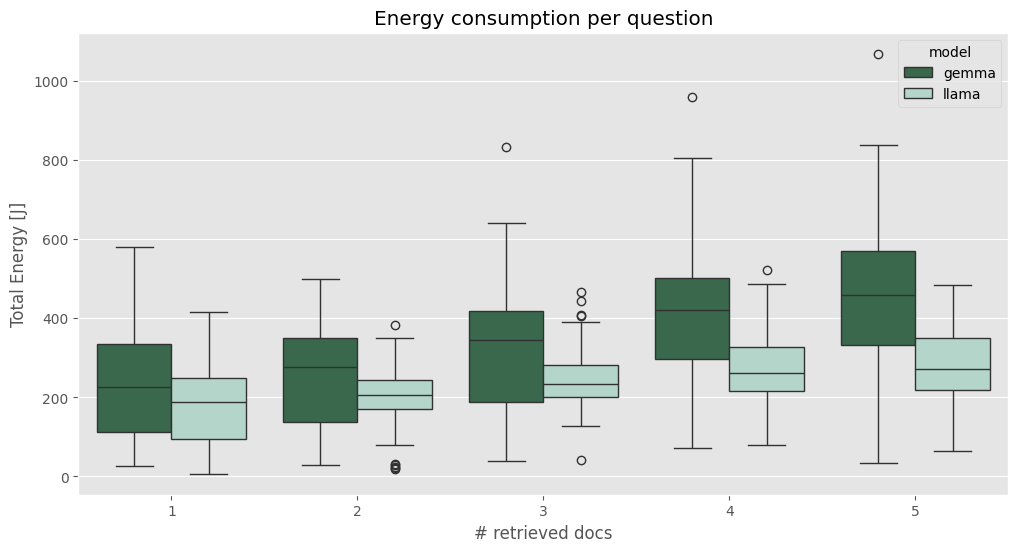

In [17]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
sns.boxplot(
    retrieved_docs_variation_runs,
    hue="model",
    y="Total Energy [J]",
    x="number retrieved docs",
    palette=[colors[1], colors[4]],
    linewidth=1,
)
plt.xlabel("# retrieved docs")
plt.title("Energy consumption per question")
fig.savefig("./figures/energy_consumption_per_question.png", dpi=500, bbox_inches="tight")

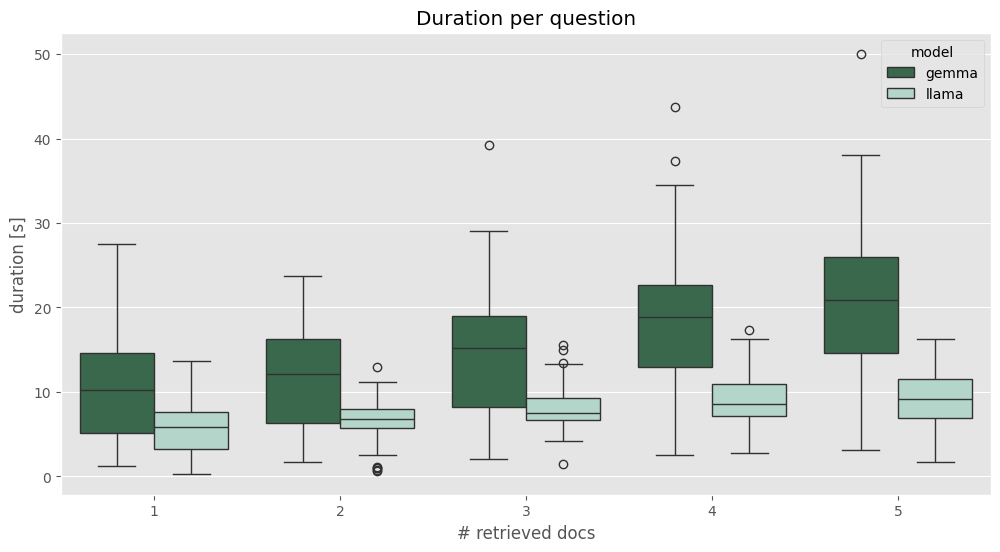

In [18]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 6)
sns.boxplot(
    retrieved_docs_variation_runs,
    hue="model",
    y="duration [s]",
    x="number retrieved docs",
    palette=[colors[1], colors[4]],
    linewidth=1,
)
plt.xlabel("# retrieved docs")
plt.title("Duration per question")
fig.savefig("./figures/duration_per_question.png", dpi=500, bbox_inches="tight")

In [19]:
pd.DataFrame(
    (
        gemma_retrieved_docs_variation_runs.drop("model", axis=1)
        / llama_retrieved_docs_variation_runs.drop("model", axis=1)
    )
    .drop(["number retrieved docs", "prompts_tokens_no", "answers_tokens_no"], axis=1)
    .mean()
).rename({0: "Gemma / Llama"}, axis=1)

,Gemma / Llama
CPU Cores Energy [J],7.428901
DRAM Energy [J],13.342937
GPU Energy [J],1.355990
Total Energy [J],1.902690
duration [s],2.567771


In [20]:
compute_wilcoxon(retrieved_docs_variation_runs, "llama", "gemma", "duration [s]", "model")

WilcoxonResult(statistic=np.float64(10611.0), pvalue=np.float64(1.4559261500692121e-58))

In [21]:
compute_wilcoxon(retrieved_docs_variation_runs, "llama", "gemma", "Total Energy [J]", "model")

WilcoxonResult(statistic=np.float64(26110.0), pvalue=np.float64(6.803174076508709e-30))